<a href="https://colab.research.google.com/github/Roflz/stock-prediction/blob/main/predict_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
30/30 [==============================] - 22s 403ms/step - loss: 0.0181
Epoch 2/50
30/30 [==============================] - 9s 298ms/step - loss: 0.0031
Epoch 3/50
30/30 [==============================] - 9s 308ms/step - loss: 0.0026
Epoch 4/50
30/30 [==============================] - 8s 257ms/step - loss: 0.0024
Epoch 5/50
30/30 [==============================] - 10s 352ms/step - loss: 0.0020
Epoch 6/50
30/30 [==============================] - 8s 262ms/step - loss: 0.0022
Epoch 7/50
30/30 [==============================] - 8s 253ms/step - loss: 0.0024
Epoch 8/50
30/30 [==============================] - 9s 287ms/step - loss: 0.0018
Epoch 9/50
30/30 [==============================] - 9s 301ms/step - loss: 0.0021
Epoch 10/50
30/30 [==============================] - 7s 251ms/step - loss: 0.0020
Epoch 11/50
30/30 [==============================] - 7s 242ms/step - loss: 0.0020
Epoch 12/50
30/30 [==============================] - 8s 262ms/step - loss: 0.0022
Epoch 13/50
30/30 [====

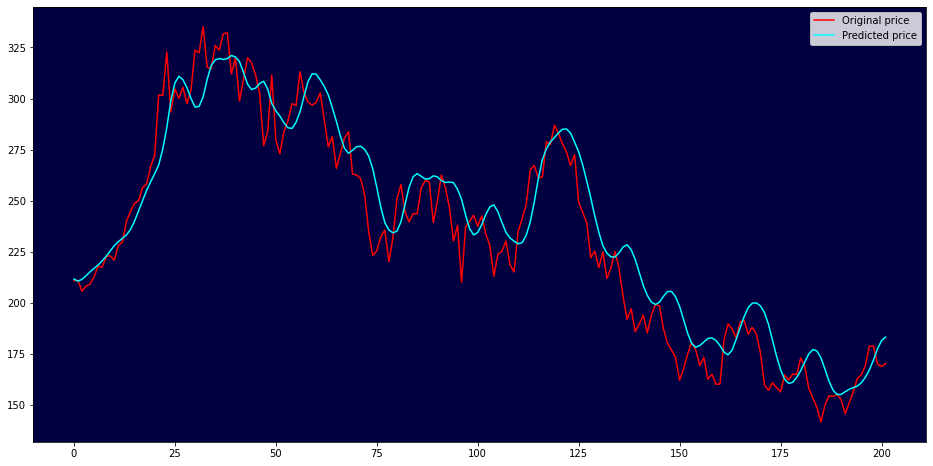

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from google.colab import files

# function to help create the datasets
# for features (x), appends the last 50 prices
# for labels (y), appends the next price
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

# Request data via Yahoo public API
# currently reads in 5 years of data as default
df = pdr.get_data_yahoo('NVDA')

# upload files and read csv (optional)
# df = files.upload()
# df = pd.read_csv(df)

# get number of trading days
df.shape

# set dimensions of dataset
df = df['Open'].values
df = df.reshape(-1, 1)

# split the data into training and testing sets
# training set is taking 1st 20% of data points (Oldest 20% of data points)
# test set is taking last 80% of data points (Most recent 80% of data points)
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])

# scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

# create datasets using function
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

# initialize model as a sequential one with 96 units in the output’s dimensionality
# use return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset
# Making the dropout fraction 0.2 drops 20% of the layers
# Finally add a dense layer with a value of 1 because we want to output one value
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# reshape data into 3d array for LSTM because it is sequential_3 which is expecting 3 dimensions, not 2
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# now compile the model
# used loss='mean_squared_error' because it is a regression problem
# use the adam optimizer to update network weights iteratively based on training data
model.compile(loss='mean_squared_error', optimizer='adam')

# Save model and start training!
# Every epoch refers to one cycle through the full training dataset
# batch size refers to the number of training examples utilized in one iteration
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

# load fitted model
model = load_model('stock_prediction.h5')

# visualize data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()